In [1]:
import math
import qiskit
import cirq
from bqskit import Circuit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit_ibm_provider import IBMProvider
import matplotlib.pyplot as plt
import os

In [2]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

In [3]:
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])


In [4]:
def circuit_11period15(qc,qr,cr):
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

In [5]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='text')

┌───┐                       ┌───┐                                     »
q_0: ┤ X ├───────────────────────┤ X ├─────────────────────────────X───────»
     └───┘                       └─┬─┘                             │       »
q_1: ──────────────────────────────┼───────────────────────────────X──X────»
                            ┌───┐  │                               │  │    »
q_2: ───────────────────────┤ X ├──┼───────────────────────────────┼──X──X─»
                            └─┬─┘  │                               │  │  │ »
q_3: ─────────────────────────┼────┼───────────────────────────────┼──┼──X─»
     ┌───┐┌───┐┌─┐     ┌───┐  │    │  ┌────────┐┌───┐┌─┐     ┌───┐ │  │  │ »
q_4: ┤ H ├┤ H ├┤M├─|0>─┤ H ├──■────■──┤ P(π/2) ├┤ H ├┤M├─|0>─┤ H ├─■──■──■─»
     └───┘└───┘└╥┘     └───┘          └───╥────┘└───┘└╥┘     └───┘         »
                ║                      ┌──╨──┐        ║                    »
c: 5/═══════════╩══════════════════════╡ 0x1 ╞════════╩════════════════════»
                0                      └─────┘        1                    »
«                    ┌───┐                                       
«q_0: ───────────────┤ X ├───────────────────────────────────────
«               ┌───┐└─┬─┘                                       
«q_1: ──────────┤ X ├──┼─────────────────────────────────────────
«          ┌───┐└─┬─┘  │                                         
«q_2: ─────┤ X ├──┼────┼─────────────────────────────────────────
«     ┌───┐└─┬─┘  │    │                                         
«q_3: ┤ X ├──┼────┼────┼─────────────────────────────────────────
«     └─┬─┘  │    │    │  ┌─────────┐┌────────┐┌────────┐┌───┐┌─┐
«q_4: ──■────■────■────■──┤ P(3π/4) ├┤ P(π/2) ├┤ P(π/4) ├┤ H ├┤M├
«                         └────╥────┘└───╥────┘└───╥────┘└───┘└╥┘
«                           ┌──╨──┐   ┌──╨──┐   ┌──╨──┐        ║ 
«c: 5/══════════════════════╡ 0x3 ╞═══╡ 0x2 ╞═══╡ 0x1 ╞════════╩═
«                           └─────┘   └─────┘   └─────┘        2

In [6]:
# Load it into BQSKit
from bqskit.ext import qiskit_to_bqskit
bqskit_shor = qiskit_to_bqskit(shor)

LangException: BQSKit currently does not support resets.

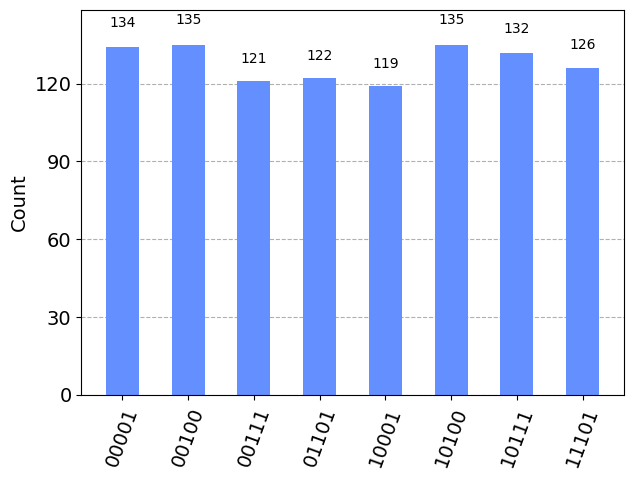

In [24]:
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)


In [25]:
# Load it into BQSKit
from bqskit.ext import qiskit_to_bqskit
bqskit_shor = qiskit_to_bqskit(shor)

LangException: BQSKit currently does not support mid-circuit measurements. Unable to apply a gate on the same qubit where a measurement has been previously made.

In [6]:
import cirq
import math
from cirq.contrib.svg import SVGCircuit

def circuit_amod15(qc, qr, cr, a):
    if a == 2:
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[2]))
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[1]))
        qc.append(cirq.CSWAP(qr[4], qr[1], qr[0]))
    elif a == 7:
        qc.append(cirq.CSWAP(qr[4], qr[1], qr[0]))
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[1]))
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[2]))
        qc.append(cirq.CX(qr[4], qr[3]))
        qc.append(cirq.CX(qr[4], qr[2]))
        qc.append(cirq.CX(qr[4], qr[1]))
        qc.append(cirq.CX(qr[4], qr[0]))
    elif a == 8:
        qc.append(cirq.CSWAP(qr[4], qr[1], qr[0]))
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[1]))
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[2]))
    elif a == 11:
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[0]))
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[1]))
        qc.append(cirq.CX(qr[4], qr[3]))
        qc.append(cirq.CX(qr[4], qr[2]))
        qc.append(cirq.CX(qr[4], qr[1]))
        qc.append(cirq.CX(qr[4], qr[0]))
    elif a == 13:
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[2]))
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[1]))
        qc.append(cirq.CSWAP(qr[4], qr[1], qr[0]))
        qc.append(cirq.CX(qr[4], qr[3]))
        qc.append(cirq.CX(qr[4], qr[2]))
        qc.append(cirq.CX(qr[4], qr[1]))
        qc.append(cirq.CX(qr[4], qr[0]))

def circuit_aperiod_15(qc, qr, cr, a):
    if a == 11:
        circuit_11period_n(qc, qr, cr)
        return

    # Initialize q[0] to |1>
    qc.append(cirq.X(qr[0]))

    # Apply a**4 mod n
    qc.append([cirq.H(qr[4]), cirq.H(qr[4]), cirq.H(qr[4])])
    
    
    # Apply a**2 mod n
    qc.append(cirq.H(qr[4]))
    qc.append(cirq.CNOT(qr[4], qr[2]))
    qc.append(cirq.CNOT(qr[4], qr[0]))
    qc.append(cirq.ControlledGate(cirq.PhasedXPowGate(phase_exponent=0.5*math.pi)).on(qr[4], cr[1]))
    qc.append([cirq.H(qr[4]), cirq.H(qr[4])])
    
    
    # Apply a mod n
    qc.append(cirq.H(qr[4]))
    qc.append(cirq.CNOT(qr[4], qr[3]))
    qc.append(cirq.CNOT(qr[4], qr[2]))
    qc.append(cirq.CNOT(qr[4], qr[1]))
    qc.append(cirq.CNOT(qr[4], qr[0]))
    qc.append(cirq.ControlledGate(cirq.PhasedXPowGate(phase_exponent=0.75*math.pi)).on(cr[2], qr[4]))
    qc.append(cirq.ControlledGate(cirq.PhasedXPowGate(phase_exponent=0.5*math.pi)).on(cr[1], qr[4]))
    qc.append(cirq.ControlledGate(cirq.PhasedXPowGate(phase_exponent=0.25*math.pi)).on(cr[0], qr[4]))
    qc.append([cirq.H(qr[4]), cirq.H(qr[4])])


    
# Example usage
qubits = cirq.LineQubit.range(5)
classical_bits = cirq.LineQubit.range(3)
shor_circuit = cirq.Circuit()
circuit_aperiod_15(shor_circuit, qubits, classical_bits, 7)
print(shor_circuit)


0: ───X───────────────────X─────────────────────────────────────────X──────────────────────────────@────────────────────
                          │                                         │                              │
1: ───────────────────────┼───PhX(-0.429)───────────────────────X───┼────────────────@─────────────┼────────────────────
                          │   │                                 │   │                │             │
2: ───────────────────X───┼───┼─────────────────────────────X───┼───┼───@────────────┼─────────────┼────────────────────
                      │   │   │                             │   │   │   │            │             │
3: ───────────────────┼───┼───┼─────────────────────────X───┼───┼───┼───┼────────────┼─────────────┼────────────────────
                      │   │   │                         │   │   │   │   │            │             │
4: ───H───H───H───H───@───@───@─────────────H───H───H───@───@───@───@───PhX(0.356)───PhX(-0.429)───PhX(0.785)───

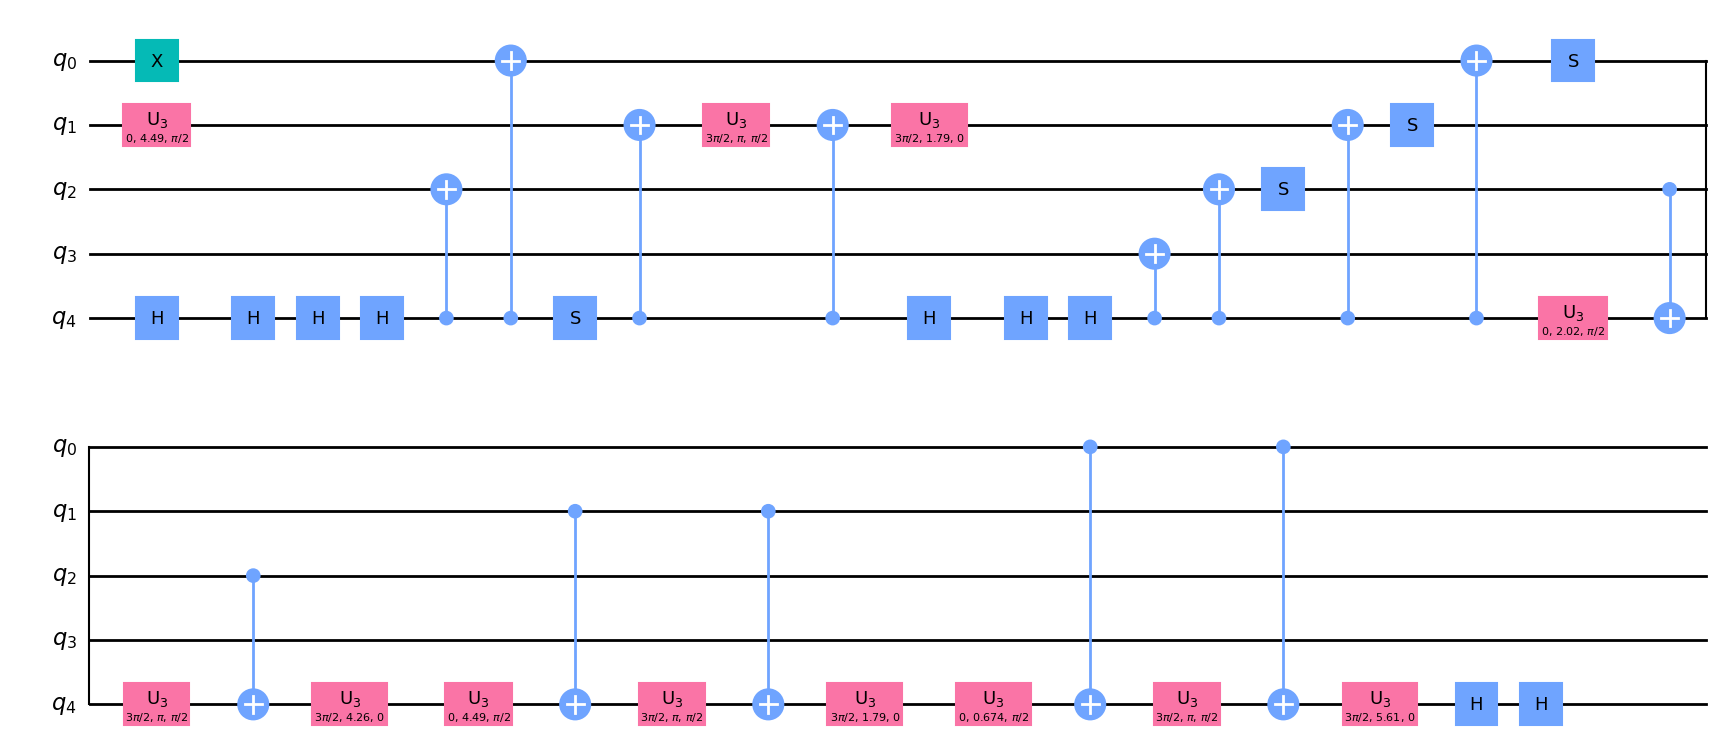

In [7]:
from mitiq.interface.mitiq_qiskit.conversions import to_qiskit
# Convertissez le circuit Cirq en circuit Qiskit
qiskit_circuit = to_qiskit(shor_circuit)
qiskit_circuit.draw(output='mpl')


In [8]:
# Load it into BQSKit
from bqskit.ext import qiskit_to_bqskit
bqskit_shor = qiskit_to_bqskit(qiskit_circuit)

In [9]:
print(bqskit_shor)

Circuit(5)[XGate@(0,) ... HGate@(4,)]


In [10]:
print("Circuit Statistics")
print("Gate Counts:", bqskit_shor.gate_counts)
print("Logical Connectivity:", bqskit_shor.coupling_graph)

Circuit Statistics
Gate Counts: {CNOTGate: 14, XGate: 1, HGate: 9, SGate: 4, U3Gate: 12}
Logical Connectivity: CouplingGraph({(2, 4), (0, 4), (3, 4), (1, 4)})


In [11]:
# Compile the circuit
from bqskit import compile
out_circuit = compile(bqskit_shor)

# Print new statistics
print("Compiled Circuit Statistics")
print("Gate Counts:", out_circuit.gate_counts)
print("Logical Connectivity:", out_circuit.coupling_graph)

Compiled Circuit Statistics
Gate Counts: {CNOTGate: 10, U3Gate: 28}
Logical Connectivity: CouplingGraph({(2, 4), (0, 4), (3, 4), (1, 4)})


In [12]:
# Compile circuit with a optimization level 2
out_circuit_lv2 = compile(bqskit_shor, optimization_level=2)

# Print new statistics
print("Compiled Circuit Statistics")
print("Gate Counts:", out_circuit_lv2.gate_counts)
print("Connectivity:", out_circuit_lv2.coupling_graph)

Compiled Circuit Statistics
Gate Counts: {CNOTGate: 10, U3Gate: 16}
Connectivity: CouplingGraph({(2, 4), (0, 4), (3, 4), (1, 4)})


In [13]:
# Compile circuit with a optimization level 3
out_circuit_lv3 = compile(bqskit_shor, optimization_level=3)

# Print new statistics
print("Compiled Circuit Statistics")
print("Gate Counts:", out_circuit_lv3.gate_counts)
print("Connectivity:", out_circuit_lv3.coupling_graph)

Compiled Circuit Statistics
Gate Counts: {CNOTGate: 10, U3Gate: 14}
Connectivity: CouplingGraph({(2, 4), (0, 4), (3, 4), (1, 4)})


In [14]:
# Compile circuit with a optimization level 4
out_circuit_lv4 = compile(bqskit_shor, optimization_level=4)

# Print new statistics
print("Compiled Circuit Statistics")
print("Gate Counts:", out_circuit_lv4.gate_counts)
print("Connectivity:", out_circuit_lv4.coupling_graph)

Compiled Circuit Statistics
Gate Counts: {CNOTGate: 10, U3Gate: 20}
Connectivity: CouplingGraph({(2, 4), (0, 4), (3, 4), (1, 4)})


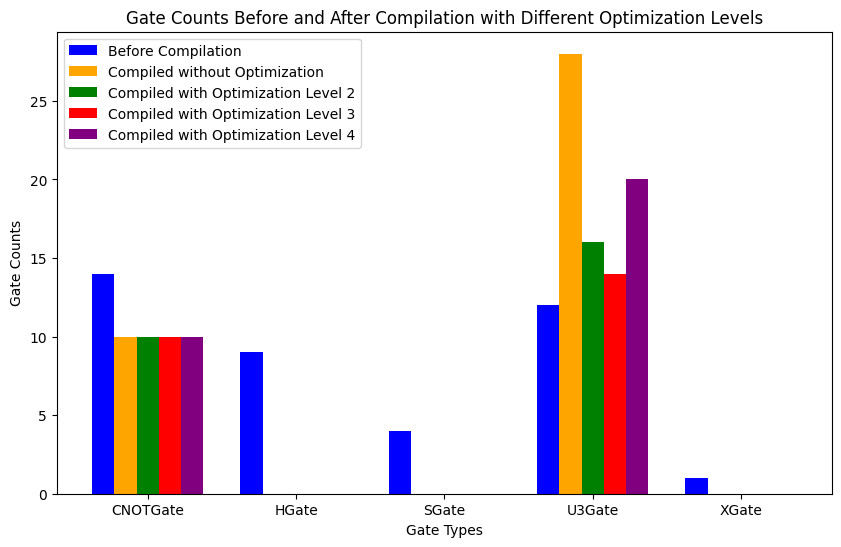

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Données
gate_counts = {
    "Before Compilation": {"CNOTGate": 14, "XGate": 1, "HGate": 9, "SGate": 4, "U3Gate": 12},
    "Compiled without Optimization": {"CNOTGate": 10, "U3Gate": 28},
    "Compiled with Optimization Level 2": {"CNOTGate": 10, "U3Gate": 16},
    "Compiled with Optimization Level 3": {"CNOTGate": 10, "U3Gate": 14},
    "Compiled with Optimization Level 4": {"CNOTGate": 10, "U3Gate": 20},
}

# Labels et couleurs
labels = list(gate_counts.keys())
gate_types = sorted(set(gate_type for count_dict in gate_counts.values() for gate_type in count_dict))
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Créer l'histogramme
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.15

for i, label in enumerate(labels):
    counts = [gate_counts[label].get(gate_type, 0) for gate_type in gate_types]
    positions = [j + width * i for j in range(len(gate_types))]
    ax.bar(positions, counts, width=width, label=label, color=colors[i])

# Paramètres de l'axe
ax.set_xticks([j + width * (len(labels) - 1) / 2 for j in range(len(gate_types))])
ax.set_xticklabels(gate_types)
ax.set_xlabel('Gate Types')
ax.set_ylabel('Gate Counts')
ax.legend()

# Titre et affichage
plt.title('Gate Counts Before and After Compilation with Different Optimization Levels')
plt.show()


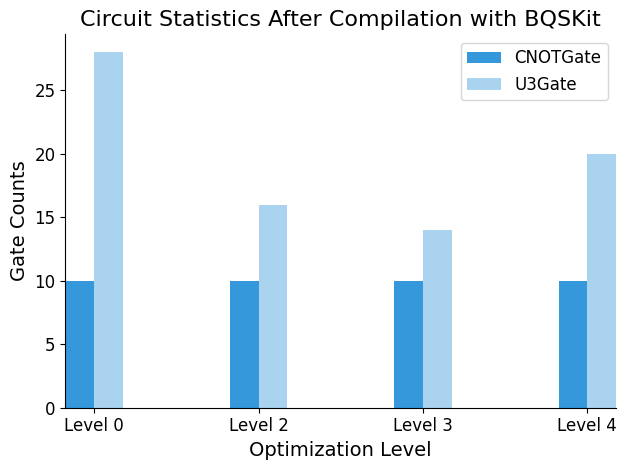

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Data
optimization_levels = [0, 1, 2, 3]  # Adjusted levels
gate_counts_cnot = [10, 10, 10, 10]
gate_counts_u3 = [28, 16, 14, 20]

# Colors for CNOTGate and U3Gate
color_cnot = '#3498db'  # Blue
color_u3 = '#85c1e9'   # Light Blue

# Bar width
bar_width = 0.35

# Create figure and axis
fig, ax = plt.subplots()

# Bar positions for CNOTGate
bar_positions_cnot = np.array(optimization_levels) - bar_width / 4
ax.bar(bar_positions_cnot, gate_counts_cnot, width=bar_width / 2, label='CNOTGate', color=color_cnot)

# Bar positions for U3Gate
bar_positions_u3 = np.array(optimization_levels) + bar_width / 4
ax.bar(bar_positions_u3, gate_counts_u3, width=bar_width / 2, label='U3Gate', color=color_u3, alpha=0.7)

# Set x-axis ticks, labels, and limits
ax.set_xticks(optimization_levels)
ax.set_xticklabels(['Level 0', 'Level 2', 'Level 3', 'Level 4'])  # Adjusted labels
ax.set_xlim([min(optimization_levels) - bar_width / 2, max(optimization_levels) + bar_width / 2])

# Add labels and title
ax.set_xlabel('Optimization Level', fontsize=14)
ax.set_ylabel('Gate Counts', fontsize=14)
ax.set_title('Circuit Statistics After Compilation with BQSKit', fontsize=16)

# Customize tick label size
ax.tick_params(axis='both', labelsize=12)

# Add legend
ax.legend(fontsize=12)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()
